# **Import necessary libraries**

In [1]:
# keras imports for the dataset and building our neural network
import keras 
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten,Input
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, UpSampling2D, Conv2D

# **Load and preprocess the CIFAR10 dataset**

In [2]:
# loading the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [3]:
print('Training data shape : ', X_train.shape, y_train.shape)

print('Testing data shape : ', X_test.shape, y_test.shape)

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)


In [4]:
#make a input vector so we 
#reshape it into input format for training and testing sets. After that change all datatypes into floats

# building the input vector from the 32x32 pixels
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [5]:
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

In [6]:
X_train.shape

(50000, 32, 32, 3)

# **Data Augmentation using the GAN**

In [7]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the generator network
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

# Define the discriminator network
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Instantiate the generator and discriminator networks
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



In [8]:
# Define a function to train the GAN on a batch of real images
@tf.function
def train_step(images):
    # Generate a batch of noise vectors
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Return the generated images
    return generated_images


In [9]:
# Train the GAN for a set number of epochs
EPOCHS = 10
noise_dim = 100
BATCH_SIZE = 128
num_examples_to_generate = 5000

# Generate a fixed noise vector for testing the generator network
test_input = tf.random.normal([num_examples_to_generate, noise_dim])

# Create empty arrays to store the augmented data and labels
augmented_data = np.zeros((num_examples_to_generate, 32, 32, 3))
augmented_labels = np.zeros((num_examples_to_generate, 1))

# Train the GAN for multiple epochs
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for i in range(num_examples_to_generate // BATCH_SIZE):
        # Sample a batch of real CIFAR10 images and their labels
        indices = np.random.choice(X_train.shape[0], BATCH_SIZE, replace=False)
        image_batch = X_train[indices, :, :, :]
        label_batch = y_train[indices, :]

        # Train the GAN on the batch of real images and get the generated images
        generated_images = train_step(image_batch)

        # Concatenate the generated images to create the augmented data
        augmented_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :, :, :] = generated_images[:BATCH_SIZE, :, :, :]
        augmented_labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = label_batch


    # Concatenate the augmented data and labels with the original data and labels
    X_train_augmented = np.concatenate([X_train, augmented_data[:X_train.shape[0]]], axis=0)
    y_train_augmented = np.concatenate([y_train, augmented_labels[:X_train.shape[0]]], axis=0)


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [10]:
# shape of training dataset after augmentation 
print(y_train_augmented.shape)
print(X_train_augmented.shape)

(55000, 1)
(55000, 32, 32, 3)


In [11]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train_augmented.shape)
y_train_augmented = np_utils.to_categorical(y_train_augmented, n_classes)
print("Shape after one-hot encoding: ", y_train_augmented.shape)

Shape before one-hot encoding:  (55000, 1)
Shape after one-hot encoding:  (55000, 10)


In [12]:
y_test = np_utils.to_categorical(y_test, n_classes)

# **custom network architecture 1**

In [13]:
# Define input shape
input_shape = (32, 32, 3)

# Define the input layer
inputs = Input(shape=input_shape)

# Define the first convolutional layer with a learning rate of 0.1
conv1 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv1')(inputs)

# Define the second convolutional layer with a learning rate of 0.05
conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2')(conv1)

# Define the max pooling layer
pool1 = MaxPooling2D(pool_size=(2, 2), name='max_pooling1')(conv2)

# Add a dropout layer to prevent overfitting
dropout1 = Dropout(rate=0.2, name='dropout1')(pool1)

# Define the third convolutional layer with a learning rate of 0.005
conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3')(dropout1)

# Define the fourth convolutional layer with a learning rate of 0.009
conv4 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv4')(conv3)

# Define the max pooling layer
pool2 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2')(conv4)

# Add a dropout layer to prevent overfitting
dropout2 = Dropout(rate=0.2, name='dropout2')(pool2)

# Define the fifth convolutional layer with a learning rate of 0.0001
conv5 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv5')(dropout2)

# Define the sixth convolutional layer with a learning rate of 0.0001
conv6 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv6')(conv5)

# Define the seventh convolutional layer with a learning rate of 0.0001
conv7 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv7')(conv6)

# Define the max pooling layer
pool3 = MaxPooling2D(pool_size=(2, 2), name='max_pooling3')(conv7)

# Add a dropout layer to prevent overfitting
dropout3 = Dropout(rate=0.25, name='dropout3')(pool3)

# Flatten the output from the max pooling layer
flatten = Flatten(name='flatten')(dropout3)

# Define the first fully connected layer
fc1 = Dense(units=512, activation='relu', name='fc1')(flatten)

# Add a dropout layer to prevent overfitting
dropout4 = Dropout(rate=0.5, name='dropout4')(fc1)

# Define the output layer
outputs = Dense(units=10, activation='softmax', name='output')(dropout4)

# Create the model
model = Model(inputs=inputs, outputs=outputs, name='my_custom_model')

# Define the optimizer with different learning rates for different convolutional layers
sgd = SGD(lr={'conv1': 0.1, 'conv2': 0.05, 'conv3': 0.005, 'conv4': 0.009, 'conv5': 0.0001})

# Compile the model with categorical cross-entropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

history=model.fit(X_train_augmented, y_train_augmented, batch_size=128, epochs=70, validation_data=(X_test, y_test))

Epoch 1/70
430/430 [==============================] - 21s 42ms/step - loss: 2.3018 - accuracy: 0.1079 - val_loss: 2.2990 - val_accuracy: 0.1707
Epoch 2/70
430/430 [==============================] - 17s 39ms/step - loss: 2.2914 - accuracy: 0.1380 - val_loss: 2.2531 - val_accuracy: 0.1957
Epoch 3/70
430/430 [==============================] - 17s 40ms/step - loss: 2.1812 - accuracy: 0.1896 - val_loss: 2.0233 - val_accuracy: 0.2671
Epoch 4/70
430/430 [==============================] - 18s 42ms/step - loss: 2.0808 - accuracy: 0.2328 - val_loss: 1.9662 - val_accuracy: 0.2923
Epoch 5/70
430/430 [==============================] - 18s 43ms/step - loss: 2.0158 - accuracy: 0.2566 - val_loss: 2.0818 - val_accuracy: 0.2538
Epoch 6/70
430/430 [==============================] - 18s 42ms/step - loss: 1.9416 - accuracy: 0.2878 - val_loss: 1.7991 - val_accuracy: 0.3490
Epoch 7/70
430/430 [==============================] - 18s 41ms/step - loss: 1.8653 - accuracy: 0.3191 - val_loss: 1.7960 - val_accuracy:

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.6280072927474976
Test accuracy: 0.7832000255584717


In [15]:
# record the training and validation accuracy and loss after each epoch
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# save the training log in a file
with open('archi_1_logfile.txt', 'w') as f:
    for i in range(len(train_acc)):
        f.write("Epoch {}: train_acc = {}, train_loss = {}, val_acc = {}, val_loss = {}\n".format(
            i+1, train_acc[i], train_loss[i], val_acc[i], val_loss[i]))

In [16]:
# save the test accuracy and loss in the training log file
with open('archi_1_logfile.txt', 'a') as f:
    f.write("Test accuracy = {}, Test loss = {}\n".format(test_acc, test_loss))

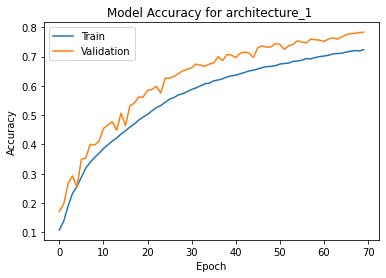

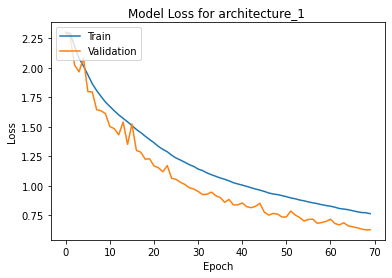

In [17]:
# plot the training and validation accuracy curves
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy for architecture_1 ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Archi_1_accuracy.png')
plt.show()

# plot the training and validation loss curves
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss for architecture_1 ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Archi_1_accuracy_loss.png')
plt.show()


# **custom network architecture 2**

In [18]:


# Define input shape
input_shape = (32, 32, 3)

# Define the input layer
inputs = Input(shape=input_shape)

# Define the first convolutional layer with a learning rate of 0.01
conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv1')(inputs)

# Define the second convolutional layer with a learning rate of 0.005
conv2 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv2')(conv1)

# Define the third convolutional layer with a learning rate of 0.001
conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3')(conv2)

# Define the fourth convolutional layer with a learning rate of 0.0005
conv4 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv4')(conv3)

# Define the fifth convolutional layer with a learning rate of 0.0001
conv5 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv5')(conv4)

# Define the fifth convolutional layer with a learning rate of 0.0001
conv6 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv6')(conv5)

# Define the max pooling layer
pooling = MaxPooling2D(pool_size=(2, 2), name='max_pooling')(conv6)

# Flatten the output from the max pooling layer
flatten = Flatten(name='flatten')(pooling)

# Define the first fully connected layer
fc1 = Dense(units=256, activation='relu', name='fc1')(flatten)

# Add a dropout layer to prevent overfitting
dropout1 = Dropout(rate=0.4, name='dropout1')(fc1)

# Define the second fully connected layer
fc2 = Dense(units=128, activation='relu', name='fc2')(dropout1)

# Add a dropout layer to prevent overfitting
dropout2 = Dropout(rate=0.3, name='dropout2')(fc2)

# Define the output layer
outputs = Dense(units=10, activation='softmax', name='output')(dropout2)

# Create the model
model = Model(inputs=inputs, outputs=outputs, name='my_custom_model')

# Define the optimizer with different learning rates for different convolutional layers
sgd = SGD(lr={'conv1': 0.001, 'conv2': 0.003, 'conv3': 0.005, 'conv4': 0.0007, 'conv5': 0.0001,'conv6': 0.0009})

# Compile the model with categorical cross-entropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
history=model.fit(X_train_augmented, y_train_augmented, batch_size=150, epochs=70, validation_data=(X_test, y_test))

Epoch 1/70
367/367 [==============================] - 36s 90ms/step - loss: 2.2443 - accuracy: 0.1609 - val_loss: 2.0448 - val_accuracy: 0.2702
Epoch 2/70
367/367 [==============================] - 30s 82ms/step - loss: 2.0586 - accuracy: 0.2545 - val_loss: 1.8447 - val_accuracy: 0.3642
Epoch 3/70
367/367 [==============================] - 31s 84ms/step - loss: 1.9328 - accuracy: 0.3057 - val_loss: 1.7461 - val_accuracy: 0.4017
Epoch 4/70
367/367 [==============================] - 30s 82ms/step - loss: 1.8517 - accuracy: 0.3355 - val_loss: 1.6775 - val_accuracy: 0.4168
Epoch 5/70
367/367 [==============================] - 30s 82ms/step - loss: 1.8009 - accuracy: 0.3536 - val_loss: 1.6084 - val_accuracy: 0.4435
Epoch 6/70
367/367 [==============================] - 30s 82ms/step - loss: 1.7488 - accuracy: 0.3708 - val_loss: 1.5510 - val_accuracy: 0.4525
Epoch 7/70
367/367 [==============================] - 30s 82ms/step - loss: 1.7036 - accuracy: 0.3872 - val_loss: 1.5265 - val_accuracy:

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 1.7411259412765503
Test accuracy: 0.7017999887466431


In [20]:
# record the training and validation accuracy and loss after each epoch
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
# save the training log in a file
with open('archi_2_logfiles.txt', 'w') as f:
    for i in range(len(train_acc)):
        f.write("Epoch {}: train_acc = {}, train_loss = {}, val_acc = {}, val_loss = {}\n".format(
            i+1, train_acc[i], train_loss[i], val_acc[i], val_loss[i]))

# save the test accuracy and loss in the training log file
with open('archi_2_logfiles.txt', 'a') as f:
    f.write("Test accuracy = {}, Test loss = {}\n".format(test_acc, test_loss))

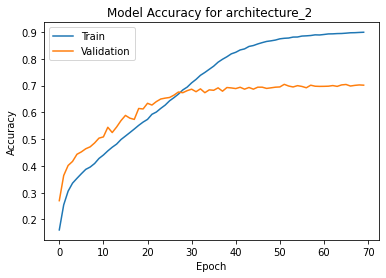

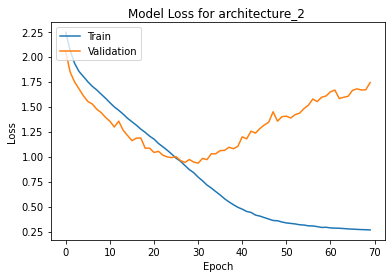

In [21]:
# plot the training and validation accuracy curves
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy for architecture_2 ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Archi_2_accuracy.png')
plt.show()

# plot the training and validation loss curves
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss for architecture_2 ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Archi_2_loss.png')
plt.show()

# **2)	Using LSTM for time serious problem recognition**

In [22]:
## Import commands of libraries 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.metrics import accuracy_score,confusion_matrix

# **Load data**

In [23]:
# read the data
data = pd.read_csv('delhi_aqi.csv')

# convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# remove hours and keep only unique dates
data = data.groupby(data['date'].dt.date).mean()
data.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3
date,,,,,,,,
2020-11-25,2971.566087,14.880000,93.549130,26.791304,82.430870,342.301739,405.037826,26.720435
2020-11-26,2314.806667,24.443750,65.418750,20.753333,65.158333,180.754167,226.001250,21.993750
2020-11-27,1592.159583,4.934167,56.221667,43.925000,41.485000,115.901667,143.952500,20.280000
2020-11-28,2461.115833,11.879583,70.046667,50.372500,41.515417,197.889167,234.861250,23.145000
2020-11-29,4516.680417,65.719583,93.949583,34.696250,77.785417,329.381667,404.049583,47.233750


# **Data preprocessing**

In [24]:
# Select the variables to use for the model
variables = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

# Fill any missing values with the mean of each variable
data[variables] = data[variables].fillna(data[variables].mean())

# Create a function to convert the time series data to a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'{data.columns[j]}(t-{i})') for j in range(n_vars)]
    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'{data.columns[j]}(t)') for j in range(n_vars)]
        else:
            names += [(f'{data.columns[j]}(t+{i})') for j in range(n_vars)]
    # Combine the input and output sequences
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Convert the time series data to a supervised learning problem
data_supervised = series_to_supervised(data[variables], n_in=24, n_out=1)

# Split the data into training and validation sets
train_size = int(len(data_supervised) * 0.8)
train_data = data_supervised[:train_size]
val_data = data_supervised[train_size:]

# Scale the data using the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)

# Split the data into input and output variables
train_X, train_y = train_data_scaled[:, :-len(variables)], train_data_scaled[:, -len(variables):]
val_X, val_y = val_data_scaled[:, :-len(variables)], val_data_scaled[:, -len(variables):]

# Reshape the input data to 3D arrays
train_X = train_X.reshape((train_X.shape[0], 24, len(variables)))
val_X = val_X.reshape((val_X.shape[0], 24, len(variables)))

# **LSTM Model**

In [25]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(24, len(variables))))
model.add(tf.keras.layers.Dense(len(variables)))
model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(train_X, train_y, epochs=50, batch_size=10,validation_data=(val_X, val_y), verbose=1)

Epoch 1/50
62/62 [==============================] - 6s 59ms/step - loss: 0.0347 - val_loss: 0.0224
Epoch 2/50
62/62 [==============================] - 3s 43ms/step - loss: 0.0183 - val_loss: 0.0209
Epoch 3/50
62/62 [==============================] - 3s 44ms/step - loss: 0.0169 - val_loss: 0.0206
Epoch 4/50
62/62 [==============================] - 3s 48ms/step - loss: 0.0166 - val_loss: 0.0201
Epoch 5/50
62/62 [==============================] - 4s 58ms/step - loss: 0.0166 - val_loss: 0.0200
Epoch 6/50
62/62 [==============================] - 3s 45ms/step - loss: 0.0156 - val_loss: 0.0196
Epoch 7/50
62/62 [==============================] - 3s 44ms/step - loss: 0.0156 - val_loss: 0.0192
Epoch 8/50
62/62 [==============================] - 3s 42ms/step - loss: 0.0150 - val_loss: 0.0190
Epoch 9/50
62/62 [==============================] - 4s 65ms/step - loss: 0.0153 - val_loss: 0.0203
Epoch 10/50
62/62 [==============================] - 3s 43ms/step - loss: 0.0153 - val_loss: 0.0187
Epoch 11/

In [26]:
# record the training and validation accuracy and loss after each epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# save the training log in a file
with open('LSTM_logfiles.txt', 'w') as f:
    for i in range(len(train_loss)):
        f.write("Epoch {}:train_loss = {},  val_loss = {}\n".format(
            i+1,  train_loss[i], val_loss[i]))


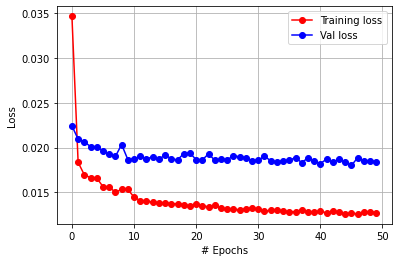

In [27]:
plt.plot(range(50), history.history['loss'], 'ro-', label="Training loss")
plt.plot(range(50), history.history['val_loss'], 'bo-', label="Val loss")
plt.xlabel("# Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# **LSTM model prediction on Validation Data**

5/5 [==============================] - 0s 6ms/step
RMSE: [0.14643268 0.17422073 0.12310749 0.07765595 0.13816755 0.12025233
 0.12442902 0.15975601]


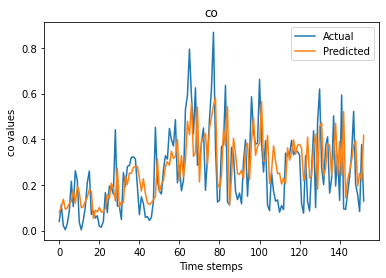

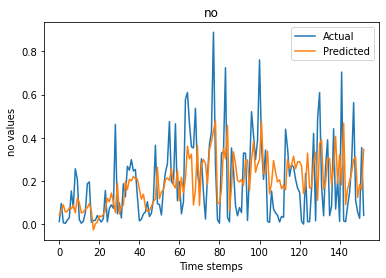

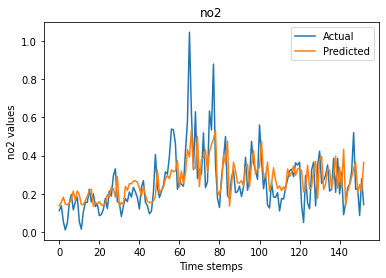

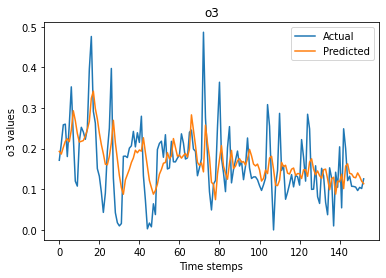

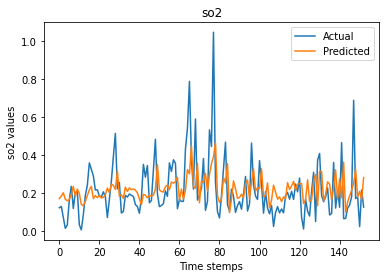

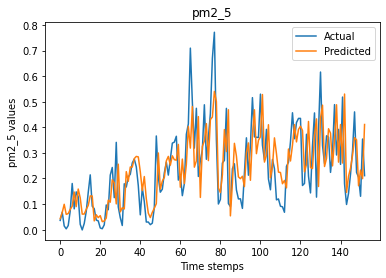

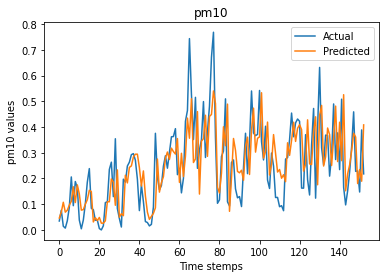

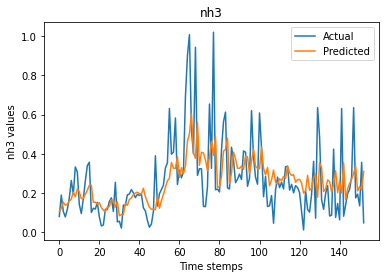

In [28]:
#  Make forecasts
# Predict the next time step for the validation data
val_pred = model.predict(val_X)


# Calculate the root mean squared error (RMSE) for each variable
rmse = np.sqrt(np.mean(np.square(val_y - val_pred), axis=0))
print(f'RMSE: {rmse}')

# Plot the predicted vs. actual values for each variable
for i, variable in enumerate(variables):
    plt.figure()
    plt.plot(val_y[:, i], label='Actual')
    plt.plot(val_pred[:, i], label='Predicted')
    plt.title(variable)
    plt.xlabel("Time stemps")
    plt.ylabel(variable+" values")
    plt.legend()
    plt.show()

# **Future Forcasting**

In [29]:
# Define the number of time steps in the input sequence
look_back = model.input_shape[1]
# Copy the last look_back days of historical data to use as a starting point for the forecast
current_input = val_X[-look_back:, :, :]
print(current_input.shape)

    
# Generate a forecast for the next days
forcasts= model.predict(current_input)

# Update the input sequence with the new forecast
current_input = np.concatenate([current_input[1:, :, :], forcasts[np.newaxis, :, :]], axis=0)

(24, 24, 8)
1/1 [==============================] - 0s 26ms/step


In [30]:
forcasts

array([[0.18054238, 0.11018506, 0.17532352, 0.14474535, 0.1326294 ,
        0.16864702, 0.1753298 , 0.17742787],
       [0.4542694 , 0.3724885 , 0.3811891 , 0.13328372, 0.31310338,
        0.4356687 , 0.44555488, 0.35333446],
       [0.47279906, 0.39017627, 0.39618868, 0.12658384, 0.31320366,
        0.48650846, 0.48381808, 0.32832512],
       [0.23834845, 0.16136883, 0.2222833 , 0.14792864, 0.15831897,
        0.24680819, 0.24822266, 0.20701486],
       [0.27238977, 0.19335279, 0.25092256, 0.14928217, 0.19176176,
        0.27844238, 0.28371078, 0.22070263],
       [0.3824342 , 0.30495214, 0.33063   , 0.12519257, 0.25858432,
        0.39432755, 0.39589545, 0.26605964],
       [0.3730802 , 0.30324125, 0.32338372, 0.09857978, 0.24569741,
        0.37681776, 0.37021926, 0.25840652],
       [0.24395914, 0.18088514, 0.22751912, 0.1258682 , 0.16347295,
        0.24921554, 0.25046203, 0.20368375],
       [0.33653164, 0.2723357 , 0.29663846, 0.12930404, 0.22654656,
        0.35108066, 0.356633

In [31]:
# Get the dates for the original data
dates = data.index[-len(val_y):]
# Create a new array of dates for the forecast
forecast_dates = pd.date_range(start=dates[-1], periods=len(forcasts)+1, freq='D')[1:]

In [32]:
dates

Index([2022-08-24, 2022-08-25, 2022-08-26, 2022-08-27, 2022-08-28, 2022-08-29,
       2022-08-30, 2022-08-31, 2022-09-01, 2022-09-02,
       ...
       2023-01-15, 2023-01-16, 2023-01-17, 2023-01-18, 2023-01-19, 2023-01-20,
       2023-01-21, 2023-01-22, 2023-01-23, 2023-01-24],
      dtype='object', name='date', length=153)

In [33]:
forecast_dates

DatetimeIndex(['2023-01-25', '2023-01-26', '2023-01-27', '2023-01-28',
               '2023-01-29', '2023-01-30', '2023-01-31', '2023-02-01',
               '2023-02-02', '2023-02-03', '2023-02-04', '2023-02-05',
               '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09',
               '2023-02-10', '2023-02-11', '2023-02-12', '2023-02-13',
               '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17'],
              dtype='datetime64[ns]', freq='D')

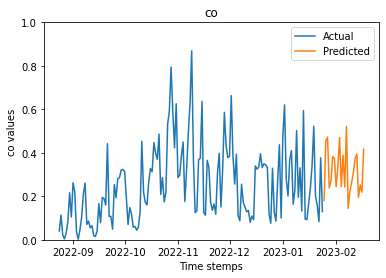

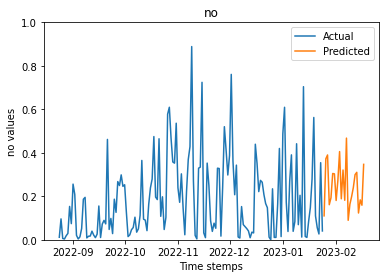

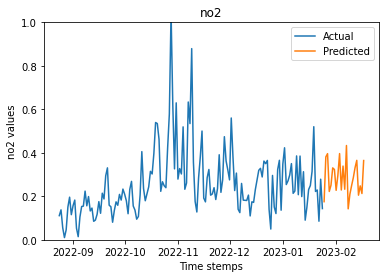

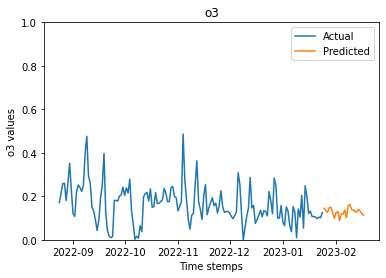

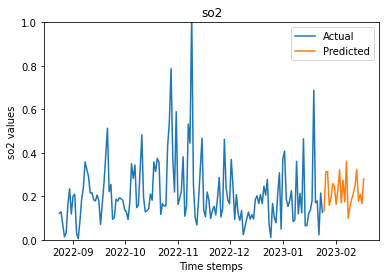

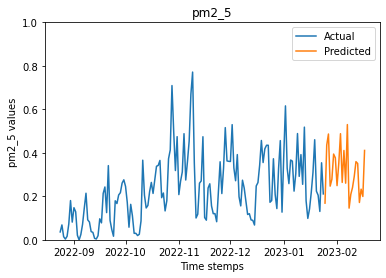

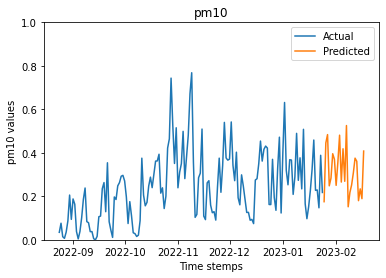

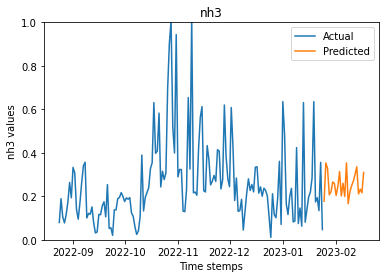

In [34]:
# Plot the predicted vs. actual values for each variable
for i, variable in enumerate(variables):
    plt.figure()
    plt.plot(dates,val_y[:, i], label='Actual')
    plt.plot(forecast_dates,np.array(forcasts)[:, i], label='Predicted')
    plt.title(variable)
    # set y-axis limits
    plt.ylim(0, 1)
    plt.xlabel("Time stemps")
    plt.ylabel(variable+" values")
    plt.legend()
    plt.show()

# **RNN Model**

In [35]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Define the RNN model
RNN_model = Sequential()
RNN_model.add(SimpleRNN(50, input_shape=(24, len(variables)), activation='relu'))
RNN_model.add(Dense(len(variables)))
RNN_model.compile(optimizer='adam', loss='mse')

# Train the model
history = RNN_model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(val_X, val_y), verbose=1)

Epoch 1/100
20/20 [==============================] - 2s 31ms/step - loss: 0.0349 - val_loss: 0.0273
Epoch 2/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0222 - val_loss: 0.0234
Epoch 3/100
20/20 [==============================] - 0s 21ms/step - loss: 0.0184 - val_loss: 0.0225
Epoch 4/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0173 - val_loss: 0.0220
Epoch 5/100
20/20 [==============================] - 1s 36ms/step - loss: 0.0161 - val_loss: 0.0215
Epoch 6/100
20/20 [==============================] - 1s 35ms/step - loss: 0.0155 - val_loss: 0.0211
Epoch 7/100
20/20 [==============================] - 1s 40ms/step - loss: 0.0150 - val_loss: 0.0209
Epoch 8/100
20/20 [==============================] - 1s 28ms/step - loss: 0.0147 - val_loss: 0.0214
Epoch 9/100
20/20 [==============================] - 0s 19ms/step - loss: 0.0145 - val_loss: 0.0207
Epoch 10/100
20/20 [==============================] - 0s 22ms/step - loss: 0.0142 - val_loss: 0.0213

In [36]:
# record the training and validation accuracy and loss after each epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# save the training log in a file
with open('RNN_logfiles.txt', 'w') as f:
    for i in range(len(train_loss)):
        f.write("Epoch {}:train_loss = {},  val_loss = {}\n".format(
            i+1,  train_loss[i], val_loss[i]))

5/5 [==============================] - 0s 4ms/step
RMSE: [0.18956657 0.21099919 0.17164875 0.09070989 0.1745436  0.16715362
 0.1710919  0.20441034]


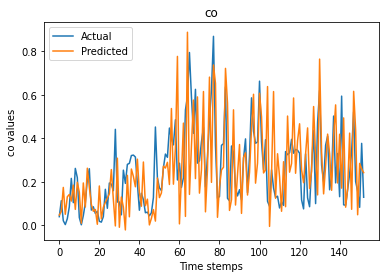

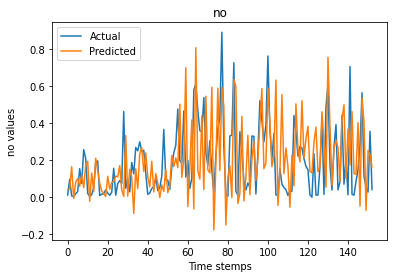

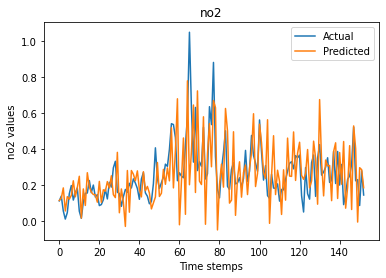

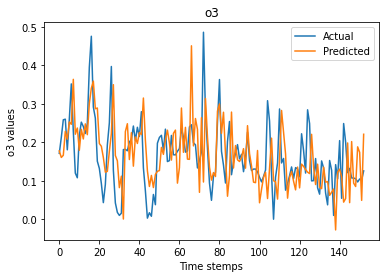

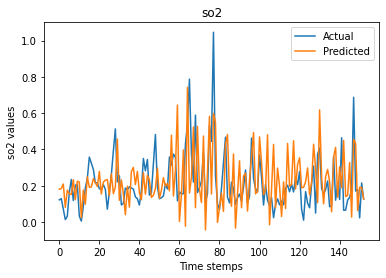

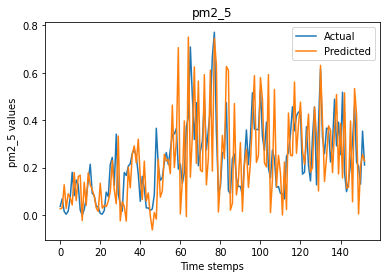

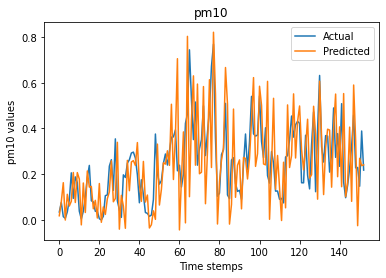

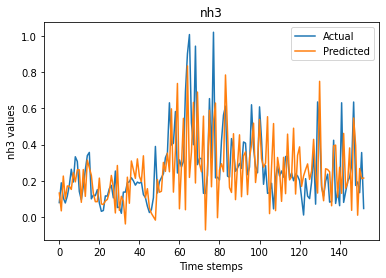

In [37]:
#  Make forecasts
# Predict the next time step for the validation data
val_pred = RNN_model.predict(val_X)


# Calculate the root mean squared error (RMSE) for each variable
rmse = np.sqrt(np.mean(np.square(val_y - val_pred), axis=0))
print(f'RMSE: {rmse}')

# Plot the predicted vs. actual values for each variable
for i, variable in enumerate(variables):
    plt.figure()
    plt.plot(val_y[:, i], label='Actual')
    plt.plot(val_pred[:, i], label='Predicted')
    plt.title(variable)
    plt.xlabel("Time stemps")
    plt.ylabel(variable+" values")
    plt.legend()
    plt.show()

In [38]:
# Define the number of time steps in the input sequence
look_back = RNN_model.input_shape[1]
# Copy the last look_back days of historical data to use as a starting point for the forecast
current_input = val_X[-look_back:, :, :]
print(current_input.shape)

    
# Generate a forecast for the next day
forecast_RNN = RNN_model.predict(current_input)

# Update the input sequence with the new forecast
current_input = np.concatenate([current_input[1:, :, :], forecast_RNN[np.newaxis, :, :]], axis=0)

(24, 24, 8)
1/1 [==============================] - 0s 21ms/step


In [39]:
forecast_RNN

array([[ 0.14045781,  0.05353778,  0.09272487,  0.14289714,  0.10630492,
         0.10145136,  0.09061924,  0.13225621],
       [ 0.7642404 ,  0.7530835 ,  0.6731398 ,  0.08333743,  0.61784834,
         0.6315372 ,  0.60662985,  0.7494204 ],
       [ 0.33319247,  0.38132793,  0.32684803,  0.07910263,  0.2507935 ,
         0.39627323,  0.3589099 ,  0.17550036],
       [ 0.14517969,  0.064057  ,  0.13889645,  0.13521868,  0.10020062,
         0.14172201,  0.11067929,  0.08987018],
       [ 0.27399457,  0.26378456,  0.33761877,  0.09601511,  0.2492105 ,
         0.24262962,  0.31462768,  0.26664212],
       [ 0.4196214 ,  0.30715466,  0.30517465,  0.0977467 ,  0.29001954,
         0.3763792 ,  0.3965724 ,  0.26248258],
       [ 0.32930088,  0.26731506,  0.30776924,  0.06179641,  0.22134984,
         0.358941  ,  0.39270326,  0.2494035 ],
       [ 0.16147122,  0.08229062,  0.11237754,  0.07004965,  0.05632821,
         0.17926827,  0.14296855,  0.06213985],
       [ 0.41299027,  0.4156357 

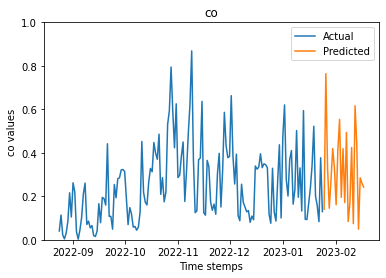

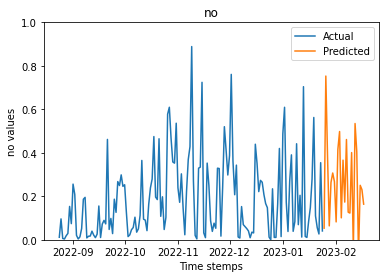

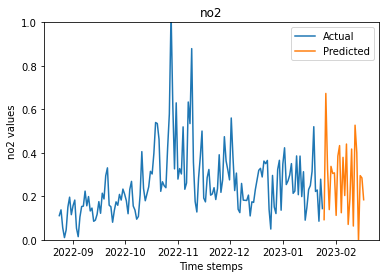

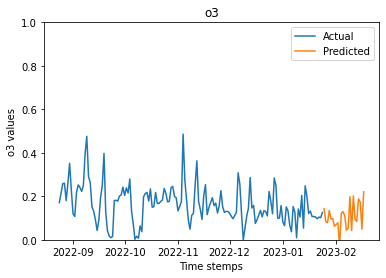

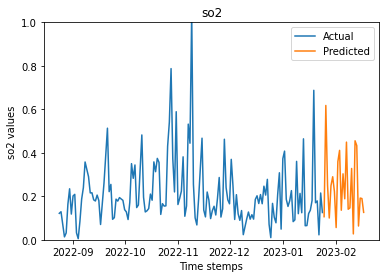

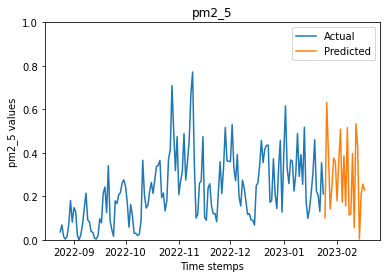

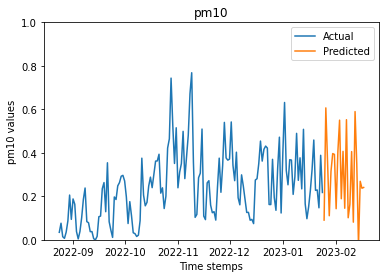

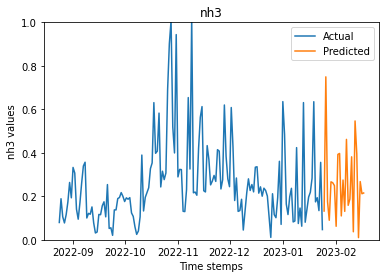

In [40]:
# Plot the predicted vs. actual values for each variable
for i, variable in enumerate(variables):
    plt.figure()
    plt.plot(dates,val_y[:, i], label='Actual')
    plt.plot(forecast_dates,np.array(forecast_RNN)[:, i], label='Predicted')
    plt.title(variable)
    # set y-axis limits
    plt.ylim(0, 1)
    plt.xlabel("Time stemps")
    plt.ylabel(variable+" values")
    plt.legend()
    plt.show()